In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import welch, cwt
from scipy.fftpack import fft
from scipy import signal

from collections import defaultdict, Counter

In [2]:
def detect_peaks(x, mph=None, mpd=1, threshold=0, edge='rising',
                 kpsh=False, valley=False, show=False, ax=None):

    """Detect peaks in data based on their amplitude and other features.

    Parameters
    ----------
    x : 1D array_like
        data.
    mph : {None, number}, optional (default = None)
        detect peaks that are greater than minimum peak height.
    mpd : positive integer, optional (default = 1)
        detect peaks that are at least separated by minimum peak distance (in
        number of data).
    threshold : positive number, optional (default = 0)
        detect peaks (valleys) that are greater (smaller) than `threshold`
        in relation to their immediate neighbors.
    edge : {None, 'rising', 'falling', 'both'}, optional (default = 'rising')
        for a flat peak, keep only the rising edge ('rising'), only the
        falling edge ('falling'), both edges ('both'), or don't detect a
        flat peak (None).
    kpsh : bool, optional (default = False)
        keep peaks with same height even if they are closer than `mpd`.
    valley : bool, optional (default = False)
        if True (1), detect valleys (local minima) instead of peaks.
    show : bool, optional (default = False)
        if True (1), plot data in matplotlib figure.
    ax : a matplotlib.axes.Axes instance, optional (default = None).

    Returns
    -------
    ind : 1D array_like
        indeces of the peaks in `x`.

    Notes
    -----
    The detection of valleys instead of peaks is performed internally by simply
    negating the data: `ind_valleys = detect_peaks(-x)`
    
    The function can handle NaN's 

    See this IPython Notebook [1]_.

    References
    ----------
    .. [1] http://nbviewer.ipython.org/github/demotu/BMC/blob/master/notebooks/DetectPeaks.ipynb

    Examples
    --------
    >>> from detect_peaks import detect_peaks
    >>> x = np.random.randn(100)
    >>> x[60:81] = np.nan
    >>> # detect all peaks and plot data
    >>> ind = detect_peaks(x, show=True)
    >>> print(ind)

    >>> x = np.sin(2*np.pi*5*np.linspace(0, 1, 200)) + np.random.randn(200)/5
    >>> # set minimum peak height = 0 and minimum peak distance = 20
    >>> detect_peaks(x, mph=0, mpd=20, show=True)

    >>> x = [0, 1, 0, 2, 0, 3, 0, 2, 0, 1, 0]
    >>> # set minimum peak distance = 2
    >>> detect_peaks(x, mpd=2, show=True)

    >>> x = np.sin(2*np.pi*5*np.linspace(0, 1, 200)) + np.random.randn(200)/5
    >>> # detection of valleys instead of peaks
    >>> detect_peaks(x, mph=0, mpd=20, valley=True, show=True)

    >>> x = [0, 1, 1, 0, 1, 1, 0]
    >>> # detect both edges
    >>> detect_peaks(x, edge='both', show=True)

    >>> x = [-2, 1, -2, 2, 1, 1, 3, 0]
    >>> # set threshold = 2
    >>> detect_peaks(x, threshold = 2, show=True)
    """

    x = np.atleast_1d(x).astype('float64')
    if x.size < 3:
        return np.array([], dtype=int)
    if valley:
        x = -x
    # find indices of all peaks
    dx = x[1:] - x[:-1]
    # handle NaN's
    indnan = np.where(np.isnan(x))[0]
    if indnan.size:
        x[indnan] = np.inf
        dx[np.where(np.isnan(dx))[0]] = np.inf
    ine, ire, ife = np.array([[], [], []], dtype=int)
    if not edge:
        ine = np.where((np.hstack((dx, 0)) < 0) & (np.hstack((0, dx)) > 0))[0]
    else:
        if edge.lower() in ['rising', 'both']:
            ire = np.where((np.hstack((dx, 0)) <= 0) & (np.hstack((0, dx)) > 0))[0]
        if edge.lower() in ['falling', 'both']:
            ife = np.where((np.hstack((dx, 0)) < 0) & (np.hstack((0, dx)) >= 0))[0]
    ind = np.unique(np.hstack((ine, ire, ife)))
    # handle NaN's
    if ind.size and indnan.size:
        # NaN's and values close to NaN's cannot be peaks
        ind = ind[np.in1d(ind, np.unique(np.hstack((indnan, indnan-1, indnan+1))), invert=True)]
    # first and last values of x cannot be peaks
    if ind.size and ind[0] == 0:
        ind = ind[1:]
    if ind.size and ind[-1] == x.size-1:
        ind = ind[:-1]
    # remove peaks < minimum peak height
    if ind.size and mph is not None:
        ind = ind[x[ind] >= mph]
    # remove peaks - neighbors < threshold
    if ind.size and threshold > 0:
        dx = np.min(np.vstack([x[ind]-x[ind-1], x[ind]-x[ind+1]]), axis=0)
        ind = np.delete(ind, np.where(dx < threshold)[0])
    # detect small peaks closer than minimum peak distance
    if ind.size and mpd > 1:
        ind = ind[np.argsort(x[ind])][::-1]  # sort ind by peak height
        idel = np.zeros(ind.size, dtype=bool)
        for i in range(ind.size):
            if not idel[i]:
                # keep peaks with the same height if kpsh is True
                idel = idel | (ind >= ind[i] - mpd) & (ind <= ind[i] + mpd) \
                    & (x[ind[i]] > x[ind] if kpsh else True)
                idel[i] = 0  # Keep current peak
        # remove the small peaks and sort back the indices by their occurrence
        ind = np.sort(ind[~idel])

    if show:
        if indnan.size:
            x[indnan] = np.nan
        if valley:
            x = -x
        _plot(x, mph, mpd, threshold, edge, valley, ax, ind)

    return ind

In [3]:
def randomize(dataset, labels):
    permutation = np.random.permutation(labels.shape[0])
    shuffled_dataset = dataset[permutation, :, :]
    shuffled_labels = labels[permutation]
    return shuffled_dataset, shuffled_labels

# 0. Loading the signals from file

In [4]:
activities_description = {
    1: 'walking',
    2: 'walking upstairs',
    3: 'walking downstairs',
    4: 'sitting',
    5: 'standing',
    6: 'laying'
}

def read_signals(filename):
    with open(filename, 'r') as fp:
        data = fp.read().splitlines()
        data = map(lambda x: x.rstrip().lstrip().split(), data)
        data = [list(map(float, line)) for line in data]
    return data

def read_labels(filename):        
    with open(filename, 'r') as fp:
        activities = fp.read().splitlines()
        activities = list(map(int, activities))
    return activities

In [5]:
def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[len(result)//2:]

In [7]:
INPUT_FOLDER_TRAIN = './data/UCI_HAR/train/InertialSignals/'
INPUT_FOLDER_TEST = './data/UCI_HAR/test/InertialSignals/'

INPUT_FILES_TRAIN = ['body_acc_x_train.txt', 'body_acc_y_train.txt', 'body_acc_z_train.txt', 
                     'body_gyro_x_train.txt', 'body_gyro_y_train.txt', 'body_gyro_z_train.txt',
                     'total_acc_x_train.txt', 'total_acc_y_train.txt', 'total_acc_z_train.txt']

INPUT_FILES_TEST = ['body_acc_x_test.txt', 'body_acc_y_test.txt', 'body_acc_z_test.txt', 
                     'body_gyro_x_test.txt', 'body_gyro_y_test.txt', 'body_gyro_z_test.txt',
                     'total_acc_x_test.txt', 'total_acc_y_test.txt', 'total_acc_z_test.txt']

LABELFILE_TRAIN = './data/UCI_HAR/train/y_train.txt'
LABELFILE_TEST = './data/UCI_HAR/test/y_test.txt'

train_signals, test_signals = [], []

for input_file in INPUT_FILES_TRAIN:
    signal = read_signals(INPUT_FOLDER_TRAIN + input_file)
    train_signals.append(signal)
train_signals = np.transpose(np.array(train_signals), (1, 2, 0))

for input_file in INPUT_FILES_TEST:
    signal = read_signals(INPUT_FOLDER_TEST + input_file)
    test_signals.append(signal)
test_signals = np.transpose(np.array(test_signals), (1, 2, 0))

train_labels = read_labels(LABELFILE_TRAIN)
test_labels = read_labels(LABELFILE_TEST)

[no_signals_train, no_steps_train, no_components_train] = np.shape(train_signals)
[no_signals_test, no_steps_test, no_components_test] = np.shape(test_signals)
no_labels = len(np.unique(train_labels[:]))

print("The train dataset contains {} signals, each one of length {} and {} components ".format(no_signals_train, no_steps_train, no_components_train))
print("The test dataset contains {} signals, each one of length {} and {} components ".format(no_signals_test, no_steps_test, no_components_test))
print("The train dataset contains {} labels, with the following distribution:\n {}".format(np.shape(train_labels)[0], Counter(train_labels[:])))
print("The test dataset contains {} labels, with the following distribution:\n {}".format(np.shape(test_labels)[0], Counter(test_labels[:])))

train_signals, train_labels = randomize(train_signals, np.array(train_labels))
test_signals, test_labels = randomize(test_signals, np.array(test_labels))

The train dataset contains 7352 signals, each one of length 128 and 9 components 
The test dataset contains 2947 signals, each one of length 128 and 9 components 
The train dataset contains 7352 labels, with the following distribution:
 Counter({6: 1407, 5: 1374, 4: 1286, 1: 1226, 2: 1073, 3: 986})
The test dataset contains 2947 labels, with the following distribution:
 Counter({6: 537, 5: 532, 1: 496, 4: 491, 2: 471, 3: 420})


# 1. Visualizing the signals

In [7]:
labels = ['x-component', 'y-component', 'z-component']
ylimits = [[-1,1], [-2, 2], [-1,2]]
axtitles = ['acceleration', 'gyro', 'total acceleration']
colors = ['r', 'g', 'b']
T = 2.56/128
N = 128
sample_rate = T

C:\Users\taspinara\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


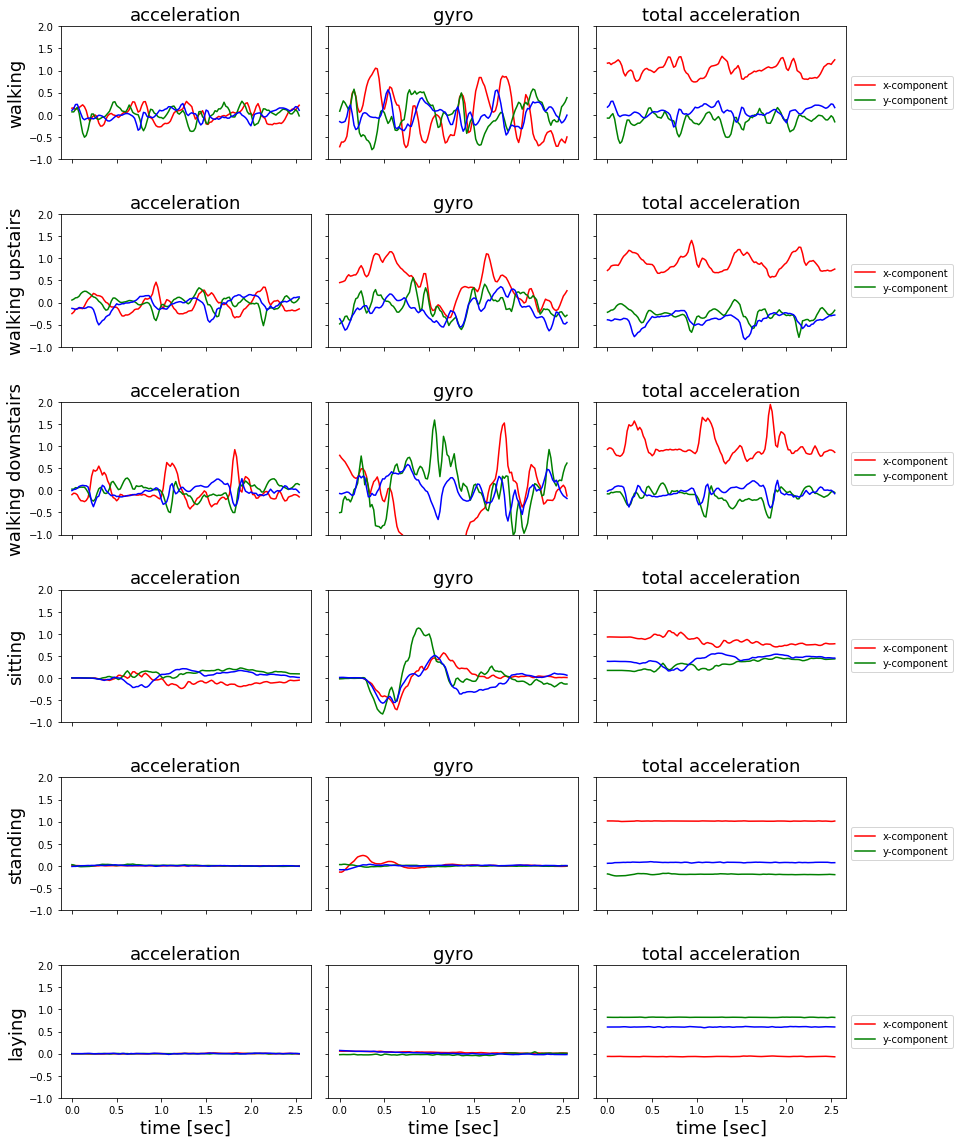

In [7]:
xlabel = 'time [sec]'

f, axarr = plt.subplots(nrows=6, ncols=3, sharex='col', sharey='row', figsize=(12,16))
for row_no in range(len(activities_description)):
    activity_no = row_no + 1
    for jj in range(0,9):
        col_no = jj // 3
        plot_no = jj % 3
        color = colors[plot_no]
        label = labels[plot_no]
        axtitle  = axtitles[col_no]
        activity_name = activities_description[activity_no]
        
        ax = axarr[row_no, col_no]
        ax.set_title(axtitle, fontsize=18)
        ax.set_ylim(ylimits[plot_no])
        
        if row_no == 5:
            ax.set_xlabel(xlabel, fontsize=18)
        if col_no == 0:
            ax.set_ylabel(activity_name, fontsize=18)
        if col_no == 2:
            ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        
        idx = list(train_labels).index(activity_no)
        y_values = train_signals[idx, :, jj]
        t_values = [sample_rate * kk for kk in range(0,len(y_values))]
        ax.plot(t_values, y_values, linestyle='-', color=color, label=label)

plt.tight_layout()
plt.show()

# 2. Calculate the FFT

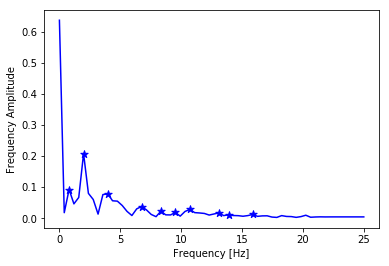

In [8]:
#The FFT of a signal can be calculated with scipy.fftpack.fft 
#The inverse FFT can be calculated with scipy.fftpack.ifft 

#Calculate the FFT of each signal, and use detect_peaks to locate the peaks.
#Play around with the mph and mpd parameters of this method to make sure you detect the peaks youre interested in
#The ideal values for these parameters will probably be different for the 9 different components

#Example on one signal:
signal = train_signals[120, :, 8]

f_values = np.linspace(0.0, 1.0/(2.0*T), N//2)
fft_values_ = fft(signal)
fft_values = 2.0/N * np.abs(fft_values_[0:N//2])

plt.plot(f_values, fft_values, linestyle='-', color='blue')

indices_peaks = detect_peaks(fft_values, mph=0.01)
plt.scatter(f_values[indices_peaks], fft_values[indices_peaks], c='blue', marker='*', s=60)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Frequency Amplitude')
plt.show()

# 3.  Calculate the Power Spectral Density

C:\Users\taspinara\AppData\Local\Continuum\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1633: UserWarning: nperseg = 256 is greater than input length  = 128, using nperseg = 128
  .format(nperseg, input_length))


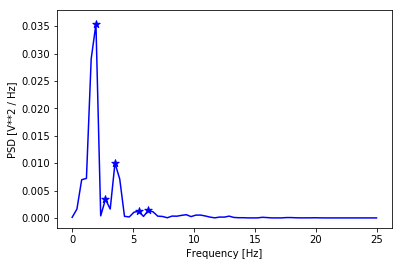

In [9]:
#The PSD of a signal can be calculated with scipy.signal.welch

#Calculate the PSD of each signal, and use detect_peaks to locate the peaks.
#Play around with the mph and mpd parameters of this method to make sure you detect the peaks youre interested in
#The ideal values for these parameters will probably be different for the 9 different components

#Example on one signal:
signal = train_signals[120, :, 8]

f_values, psd_values = welch(signal, fs=50)
indices_peaks = detect_peaks(psd_values, mph=0.001)

plt.plot(f_values, psd_values, linestyle='-', color='blue')
plt.scatter(f_values[indices_peaks], psd_values[indices_peaks], c='blue', marker='*', s=60)
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD [V**2 / Hz]')
plt.show()

# 3. Calculate the Autocorrelation

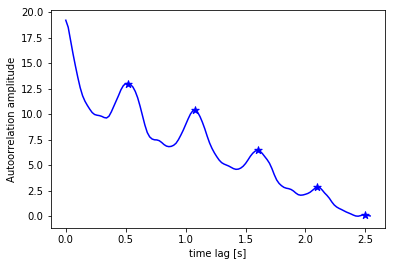

In [11]:
#There is no standard function for the autocorrelation in the scipy package. 
#But we can construct one by using np.correlate() 

#Calculate the autocorrelation of each signal, and use detect_peaks to locate the peaks.
#Play around with the mph and mpd parameters of this method to make sure you detect the peaks youre interested in
#The ideal values for these parameters will probably be different for the 9 different components

#Example on one signal:
signal = train_signals[120, :, 8]

autocorr_values = autocorr(signal)
x_values = np.array([sample_rate * jj for jj in range(0, 128)])

plt.plot(x_values, autocorr_values, linestyle='-', color='blue')
indices_peaks = detect_peaks(autocorr_values, mph=0.01)

plt.scatter(x_values[indices_peaks], autocorr_values[indices_peaks], c='blue', marker='*', s=60)

plt.xlabel('time lag [s]')
plt.ylabel('Autoorrelation amplitude')
plt.show()

# 4. Extracting features from a signal

## 4.1 Extract features from train dataset

In [8]:
FREQ = 50
CUTOFF_PERCENTAGE = 0.1
SIGNAL_LENGTH = 2.56
NO_SAMPLES = 128
PERIOD = SIGNAL_LENGTH/NO_SAMPLES
SAMPLE_RATE_AUTOCORR = (SIGNAL_LENGTH*2)/NO_SAMPLES

ylimits_fft = [[[0,0.15], [0, 1], [0,2]], 
           [[0,0.25], [0, 1], [0,2]], 
           [[0,0.4], [0,0.4], [0,2]],
           [[0,0.02], [0,0.03], [0,2]],
           [[0,0.01], [0,0.01], [0,2]],
           [[0,0.1], [0,0.4], [0,2]]
          ]

ylimits_autocorr = [
            [[-3,7], [-25, 80], [0,150]], 
           [[-5,7], [-30, 80], [0,150]], 
           [[-7,10], [-10,50], [0,150]],
           [[-0.01,0.02], [-0.2,0.2], [0,120]],
           [[-0.002,0.006], [-0.02,0.02], [0,130]],
           [[-0.6,0.5], [-7,15], [0,80]]
          ]

ylimits_psd = [[[0,0.03], [0,0.45], [0,0.03]], 
           [[0,0.05], [0,0.8], [0,0.05]], 
           [[0,0.1], [0,0.14], [0,0.1]],
           [[0,0.02], [0,0.0005], [0,0.00003]],
           [[0,0.0003], [0,0.00025], [0,0.000005]],
           [[0,0.0007], [0,0.006], [0,0.00006]]
          ]

In [9]:
def get_first_n_peaks(x,y,no_peaks=3):
    x_, y_ = list(x), list(y)
    if len(x_) >= no_peaks:
        return x_[:no_peaks], y_[:no_peaks]
    else:
        missing_no_peaks = no_peaks-len(x_)
        return x_ + [0]*missing_no_peaks, y_ + [0]*missing_no_peaks

def get_psd_features(signal, ylimits, activity_no, comp_no, freq = FREQ, cutoff_percentage = CUTOFF_PERCENTAGE):
    f_values, psd_values = welch(signal, fs=freq)
    max_val = ylimits[int(activity_no - 1)][comp_no // 3][1]
    indices_peaks = detect_peaks(psd_values, mph=max_val*cutoff_percentage)
    peaks_x, peaks_y = get_first_n_peaks(f_values[indices_peaks], psd_values[indices_peaks])
    return peaks_x + peaks_y

def get_autocorr_features(signal, ylimits, activity_no, comp_no, sample_rate = SAMPLE_RATE_AUTOCORR, no_samples = NO_SAMPLES, cutoff_percentage = CUTOFF_PERCENTAGE):
    x_values = np.array([sample_rate * jj for jj in range(0, no_samples)])
    autocorr_values = autocorr(signal)
    max_val = ylimits[int(activity_no - 1)][comp_no // 3][1]
    indices_peaks = detect_peaks(autocorr_values, mph=max_val*cutoff_percentage)
    peaks_x, peaks_y = get_first_n_peaks(x_values[indices_peaks], autocorr_values[indices_peaks])
    return peaks_x + peaks_y

def get_fft_features(signal, ylimits, activity_no, comp_no, period = PERIOD, no_samples = NO_SAMPLES, cutoff_percentage = CUTOFF_PERCENTAGE):
    f_values = np.linspace(0.0, 1.0/(2.0*period), no_samples//2)
    fft_values_ = fft(signal)
    fft_values = 2.0/no_samples * np.abs(fft_values_[0:no_samples//2])
    max_val = ylimits[int(activity_no - 1)][comp_no // 3][1]
    indices_peaks = detect_peaks(fft_values, mph=max_val*cutoff_percentage)
    peaks_x, peaks_y = get_first_n_peaks(f_values[indices_peaks], fft_values[indices_peaks])
    return peaks_x + peaks_y

In [10]:
list_of_features_train = []
list_of_labels_train = []

#Iterate over all signals, and generate n features from each signal. 
#For example, if you decide to extract the first three peaks of the FFT, PSD and autocorrelation function, 
#this should result in 9 features per component. Meaning there are n = 9 x 9 = 81 features in total per signal.
#Append this list of 81 features to list_of_features_train and append the label of the signal to list_of_labels_train

#Some components might nog contain enough information to extract three peaks (for the FFT/PSD/autocorr), 
#while other components might contain more peaks. 
#After you have a working classifier, play around with this number in order to optimize. 

labels_ = train_labels
signals_ = train_signals

for ii in range(0, signals_.shape[0]):
    features = []
    label = labels_[ii]
    list_of_labels_train.append(label)
    for jj in range(0,signals_.shape[2]):
        signal = signals_[ii, :, jj]
        features += get_psd_features(signal, ylimits_psd, label, jj)
        features += get_autocorr_features(signal, ylimits_autocorr, label, jj)
        features += get_fft_features(signal, ylimits_fft, label, jj)
    list_of_features_train.append(features)
    if ii % 1000 == 0:
        print("Processed {} signals.".format(ii))

C:\Users\taspinara\AppData\Local\Continuum\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1633: UserWarning: nperseg = 256 is greater than input length  = 128, using nperseg = 128
  .format(nperseg, input_length))


Processed 0 signals.
Processed 1000 signals.
Processed 2000 signals.
Processed 3000 signals.
Processed 4000 signals.
Processed 5000 signals.
Processed 6000 signals.
Processed 7000 signals.


## 4.2 Extract features from test dataset

In [11]:
list_of_features_test = []
list_of_labels_test = []

#Same thing for the test set. 
#Make sure you extract exactly the same features for the test set as you did for the training set.

labels_ = test_labels
signals_ = test_signals

for ii in range(0, signals_.shape[0]):
    features = []
    label = labels_[ii]
    list_of_labels_test.append(label)
    for jj in range(0,signals_.shape[2]):
        signal = signals_[ii, :, jj]
        features += get_psd_features(signal, ylimits_psd, label, jj)
        features += get_autocorr_features(signal, ylimits_autocorr, label, jj)
        features += get_fft_features(signal, ylimits_fft, label, jj)
    list_of_features_test.append(features)
    if ii % 1000 == 0:
        print("Processed {} signals.".format(ii))

C:\Users\taspinara\AppData\Local\Continuum\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1633: UserWarning: nperseg = 256 is greater than input length  = 128, using nperseg = 128
  .format(nperseg, input_length))


Processed 0 signals.
Processed 1000 signals.
Processed 2000 signals.


In [12]:
X_train = np.array(list_of_features_train)
Y_train = np.array(list_of_labels_train)
X_test = np.array(list_of_features_test)
Y_test = np.array(list_of_labels_test)

# 5. Start the classification process

In [13]:
from siml.sk_utils import *
#See https://github.com/taspinar/siml

In [14]:
dict_results = batch_classify(X_train, Y_train, X_test, Y_test)
display_dict_models(dict_results)

trained Gradient Boosting Classifier in 30.68 s
trained Random Forest in 0.20 s
trained Logistic Regression in 4.07 s
trained Nearest Neighbors in 0.09 s
trained Decision Tree in 0.35 s


,classifier,train_score,test_score,train_time
0,Gradient Boosting Classifier,0.999864,0.993553,30.676422
1,Random Forest,1.000000,0.980319,0.197620
2,Logistic Regression,0.969804,0.958602,4.069063
4,Decision Tree,1.000000,0.945368,0.346346
3,Nearest Neighbors,0.926415,0.831354,0.089869


In [26]:
colnames = []
for comp_no in range(1,10):
    for signal_type in ['psd', 'autocorr', 'fft']:
        for dim in ['x', 'y']:
            for peak_no in range(1,4):
                colname = "{}_{}_{}_{}".format(signal_type, dim, peak_no, comp_no)
                colnames.append(colname)
print(len(colnames), np.shape(X_train))

y_col = 'label'

df_train = pd.DataFrame(data = X_train, columns=colnames)
df_train.loc[:,y_col] = Y_train
df_test = pd.DataFrame(data = X_test, columns=colnames)
df_test.loc[:,y_col] = Y_test
display(df_train.head())

162 (7352, 162)


,psd_x_1_1,psd_x_2_1,psd_x_3_1,psd_y_1_1,psd_y_2_1,psd_y_3_1,autocorr_x_1_1,autocorr_x_2_1,autocorr_x_3_1,autocorr_y_1_1,...,autocorr_y_1_9,autocorr_y_2_9,autocorr_y_3_9,fft_x_1_9,fft_x_2_9,fft_x_3_9,fft_y_1_9,fft_y_2_9,fft_y_3_9,label
0,4.296875,0.000000,0.00000,0.000031,0.000000,0.000000,0.48,0.64,0.84,0.001017,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
1,1.953125,3.906250,0.00000,0.053219,0.012024,0.000000,0.96,2.00,2.92,3.669567,...,15.232775,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
2,1.953125,2.734375,3.90625,0.063404,0.016457,0.004557,0.76,1.04,2.08,0.731990,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
4,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6


In [29]:
def display_corr_matrix(df):
    correlation_matrix = df.corr()
    fig, ax = plt.subplots(figsize=(10,10))
    ax = sns.heatmap(correlation_matrix, vmax=1, square=True,annot=False,cmap='RdYlGn')
    plt.title('Correlation matrix between the features')
    #plt.colorbar(fig, orientation='vertical', fraction=0.03, label = 'Correlation strength')
    plt.show()

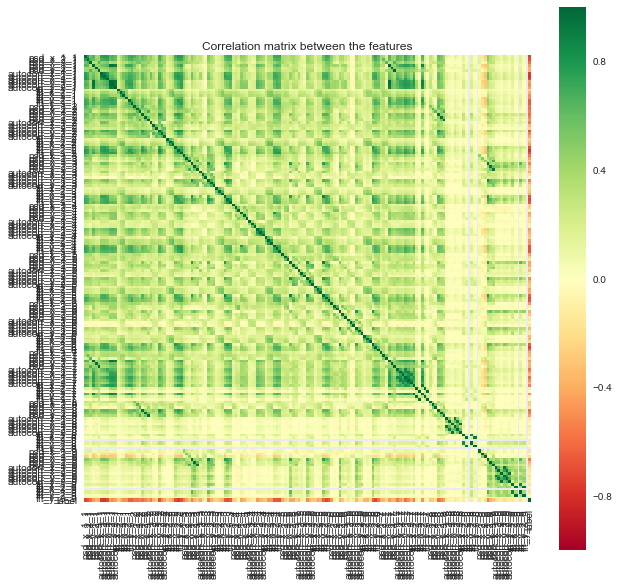

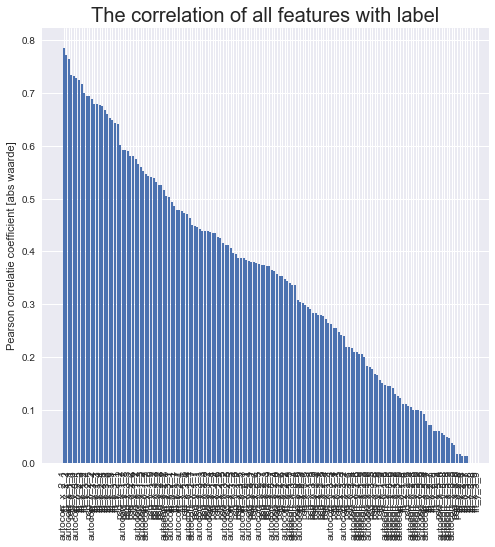

In [31]:
display_corr_matrix(df_train)
display_corr_with_col(df_train, y_col)